In [131]:
#!pip install xgboost

In [132]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder
import IPython
import scipy.stats as scs
from itertools import product
import matplotlib.patches as mpatches

## Load Data

In [192]:
# dir = 'TECO-PSDA-ExerciseSheet1-credit-2024/'
test_data = pd.read_csv('credit_test.csv', index_col=0)
train_data = pd.read_csv('credit_train.csv', index_col=0)

## Exploration

In [134]:
num_rows, num_columns = train_data.shape
print("Number of rows: ", num_rows)
print("Number of columns: ", num_columns)
train_data.head()

Number of rows:  350
Number of columns:  11


,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331
7,20.996,3388,259,2,37,12,Female,No,No,African American,203


In [135]:
# Get an overview of the data types and missing values
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 350 entries, 1 to 400
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Income     350 non-null    float64
 1   Limit      350 non-null    int64  
 2   Rating     350 non-null    int64  
 3   Cards      350 non-null    int64  
 4   Age        350 non-null    int64  
 5   Education  350 non-null    int64  
 6   Gender     350 non-null    object 
 7   Student    350 non-null    object 
 8   Married    350 non-null    object 
 9   Ethnicity  350 non-null    object 
 10  Balance    350 non-null    int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 32.8+ KB


There are no null values but some categorical values which require encoding.

## Preprocessing

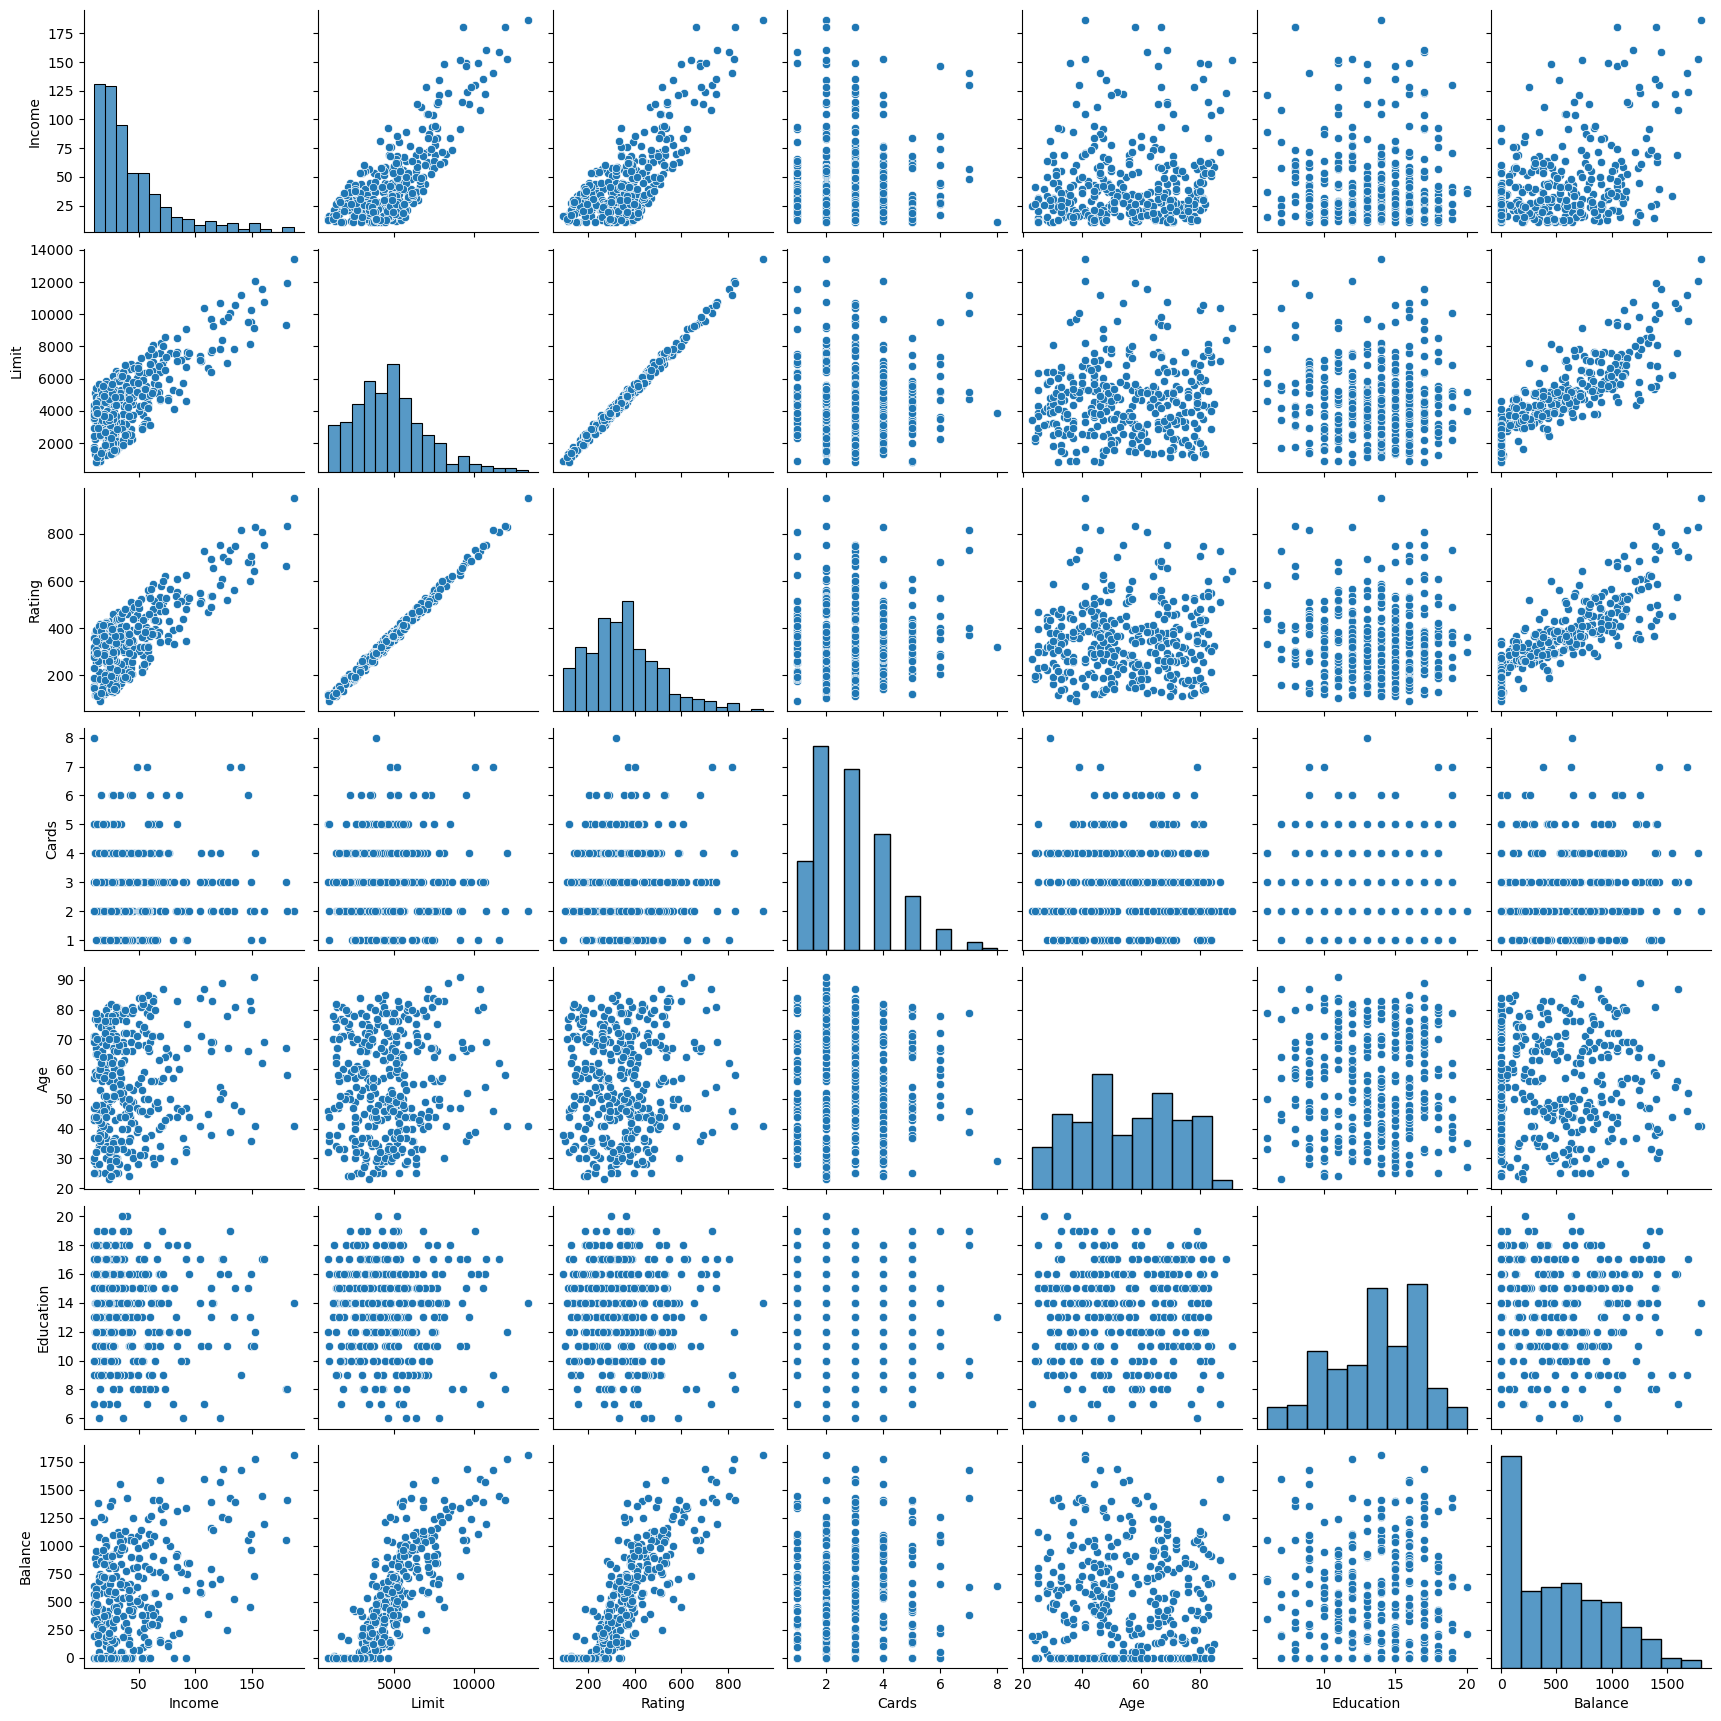

In [136]:
# Visualize distributions and relationships
sns.pairplot(train_data)
plt.show()

In [137]:
categorical_cols = ['Gender', 'Student', 'Married', 'Ethnicity']
train_data = pd.get_dummies(train_data, columns=categorical_cols)

In [138]:
# See correlation of features to target
train_data.corr()['Balance'].sort_values(ascending=False)

Balance                       1.000000
Rating                        0.857591
Limit                         0.854554
Income                        0.450618
Student_Yes                   0.287136
Cards                         0.111943
Married_No                    0.048992
Gender_Female                 0.042302
Ethnicity_African American    0.007481
Ethnicity_Asian              -0.003452
Ethnicity_Caucasian          -0.003464
Education                    -0.016612
Age                          -0.023072
Gender_Male                  -0.042302
Married_Yes                  -0.048992
Student_No                   -0.287136
Name: Balance, dtype: float64

- strong (positive) correlation: Rating, Limit, and Income
- low correlation (absolute correlation < 0.1):  Married_No, Gender_Female, Ethnicity_African American,Ethnicity_Asian, Ethnicity_Caucasian, Age, Education,  Gender_Male, Married_Yes

Check correlation between columns

In [139]:
correlation_matrix = train_data.drop('Balance', axis=1).corr()

# Define threshold for high correlation (e.g., absolute correlation > 0.7)
threshold = 0.7

# Find highly correlated features
highly_correlated = (correlation_matrix.abs() > threshold) & (correlation_matrix.abs() < 1)

# Extract list of highly correlated features
correlated_features = {}
for column in highly_correlated:
    correlated_features[column] = list(correlation_matrix.index[highly_correlated[column]])

# Print list of highly correlated features
for feature, correlated_list in correlated_features.items():
    if correlated_list:
        print(f"Features highly correlated with '{feature}': {', '.join(correlated_list)}")

Features highly correlated with 'Income': Limit, Rating
Features highly correlated with 'Limit': Income, Rating
Features highly correlated with 'Rating': Income, Limit
Features highly correlated with 'Student_No': Student_Yes
Features highly correlated with 'Student_Yes': Student_No
Features highly correlated with 'Married_No': Married_Yes
Features highly correlated with 'Married_Yes': Married_No


'Limit', 'Income' and 'Rating'  are highly correlated with each other.

### Split data into training and test set

In [161]:
X_train,X_test,y_train,y_test=train_test_split(train_data.drop(labels=['Balance'], axis=1),
    train_data['Balance'],
    test_size=0.3,
    random_state=42)
mutual_info = mutual_info_regression(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)[0:20]


Rating                        0.798657
Limit                         0.762528
Income                        0.097838
Ethnicity_Caucasian           0.087423
Cards                         0.086033
Student_No                    0.045297
Ethnicity_African American    0.044859
Gender_Female                 0.023420
Gender_Male                   0.019264
Ethnicity_Asian               0.007480
Age                           0.000000
Education                     0.000000
Student_Yes                   0.000000
Married_No                    0.000000
Married_Yes                   0.000000
dtype: float64

- high mutual informatio: Rating,  Limit
- Low Mutual Information: Gender_Male, Ethnicity_Caucasian, Gender_Female, Student_Yes, Age, Ethnicity_African American, Student_No, Education, Married_No, Married_Yes, Ethnicity_Asian

Including Ethnicity also could introduce a bias  and  lead to unfair or discriminatory outcomes. 
Student  has a low mutual information but moderate correlation, so it could still provide valuable information to the model.

Candidates for removal (based on low mutual information and weak correlation):
- Married_No
- Gender_Female
- Ethnicity_African American
- Ethnicity_Asian
- Ethnicity_Caucasian
- Education
- Age
- Gender_Male
- Married_Yes



In [163]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns #Visualization
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from scipy.stats import pearsonr


## Model Training and Evaluation

In [178]:
# Define the pipelines for each model
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

rf_pipeline = Pipeline([
    ('rf', RandomForestRegressor())
])

xgb_pipeline = Pipeline([
    ('xgb', XGBRegressor())
])


# Define parameter grids for grid search
ridge_param_grid = {
    'ridge__alpha': [0.0001, .001, 0.1, 0.5, 1, 10]
}

rf_param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 2, 10, 20],
    'rf__min_samples_leaf' : [1,2,4],
    'rf__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
}


xgb_param_grid = {
    'xgb__n_estimators': [50, 100, 200, 300],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.3],
    #'xgb__min_child_weight': [1, 3, 5],  # Minimum sum of instance weight needed in a child
    #'xgb__subsample': [0.6, 0.8, 1.0], 
    #'xgb__colsample_bytree': [0.6, 0.8, 1.0], 
    # 'xgb__gamma': [0, 0.1, 0.2], 
}



feature_subsets = [
    ("All Features", train_data.drop('Balance', axis=1)),
    ("Without 'Married_No', 'Gender_Female', 'Ethnicity_African American', 'Ethnicity_Asian', 'Ethnicity_Caucasian', 'Education', 'Age', 'Gender_Male', 'Married_Yes'", train_data.drop(['Balance', 'Married_No', 'Gender_Female', 'Ethnicity_African American', 'Ethnicity_Asian', 'Ethnicity_Caucasian', 'Education', 'Age', 'Gender_Male', 'Married_Yes'], axis=1)),    
]



for subset_name, subset_data in feature_subsets:
    print(f"Testing with subset: {subset_name}")

    # Split the subset data into training and test sets
    X_train,X_test,y_train,y_test=train_test_split(subset_data,train_data['Balance'],test_size=0.3,random_state=42)


    
    # Perform grid search for each model
    ridge_grid = GridSearchCV(ridge_pipeline, ridge_param_grid,scoring='neg_mean_absolute_error', cv=5)
    rf_grid = GridSearchCV(rf_pipeline, rf_param_grid,scoring='neg_mean_absolute_error',  cv=5)
    xgb_grid = GridSearchCV(xgb_pipeline, xgb_param_grid,scoring='neg_mean_absolute_error',  cv=5)
    
    # Train the models
    ridge_grid.fit(X_train, y_train)
    rf_grid.fit(X_train, y_train)
    xgb_grid.fit(X_train, y_train)
    
    # Make predictions using the best models
    y_pred_ridge = ridge_grid.best_estimator_.predict(X_test)
    y_pred_rf = rf_grid.best_estimator_.predict(X_test)
    y_pred_xgb = xgb_grid.best_estimator_.predict(X_test)
    
    # Calculate Mean Absolute Error (MAE) for each model
    mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
    
    # Get the best parameters for each model
    ridge_best_params = ridge_grid.best_params_
    rf_best_params = rf_grid.best_params_
    xgb_best_params = xgb_grid.best_params_

    # Calculate R-squared score for each model
    r2_ridge = r2_score(y_test, y_pred_ridge)
    r2_rf = r2_score(y_test, y_pred_rf)
    r2_xgb = r2_score(y_test, y_pred_xgb)


    print("Ridge Regression MAE:", mae_ridge)
    print("Random Forest MAE:", mae_rf)
    print("XGBoost MAE:", mae_xgb)

    print("Ridge Regression R-squared score:", r2_ridge)
    print("Random Forest R-squared score:", r2_rf)
    print("XGBoost R-squared score:", r2_xgb)
    
    print("Ridge Regression Best Parameters:", ridge_best_params)
    print("Random Forest Best Parameters:", rf_best_params)
    print("XGBoost Best Parameters:", xgb_best_params)

Testing with subset: All Features
Ridge Regression MAE: 79.59470265314762
Random Forest MAE: 66.60229505044887
XGBoost MAE: 62.030310538836886
Ridge Regression R-squared score: 0.954590353314342
Random Forest R-squared score: 0.9492374357900393
XGBoost R-squared score: 0.9517521374187052
Ridge Regression Best Parameters: {'ridge__alpha': 0.1}
Random Forest Best Parameters: {'rf__max_depth': 10, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
XGBoost Best Parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 300}
Testing with subset: Without 'Married_No', 'Gender_Female', 'Ethnicity_African American', 'Ethnicity_Asian', 'Ethnicity_Caucasian', 'Education', 'Age', 'Gender_Male', 'Married_Yes'
Ridge Regression MAE: 77.06298939050005
Random Forest MAE: 61.035264897272036
XGBoost MAE: 61.345303740955536
Ridge Regression R-squared score: 0.9581377633748012
Random Forest R-squared score: 0.9530476101793912
XGBoost R-squared score: 0.9

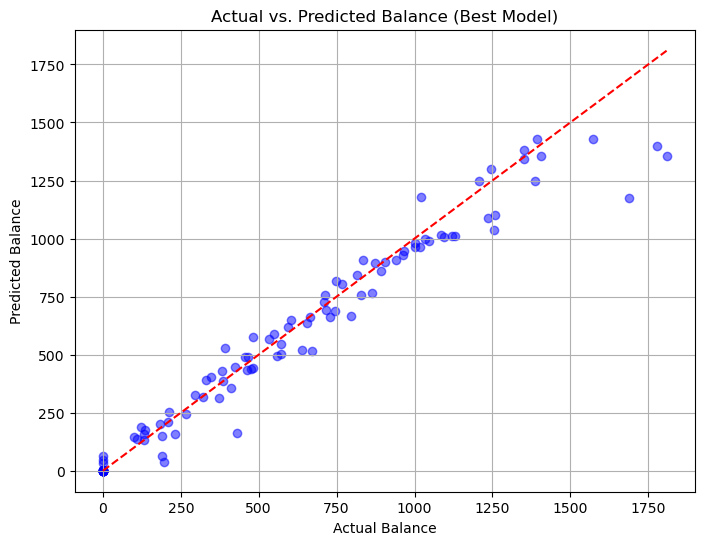

In [180]:
import matplotlib.pyplot as plt

# Choose the best model (for example, let's assume it's the XGBoost model)
#best_model = xgb_grid.best_estimator_

# Make predictions using the best model
y_pred_best = y_pred_rf

# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Balance')
plt.ylabel('Predicted Balance')
plt.title('Actual vs. Predicted Balance (Best Model)')
plt.grid(True)
plt.show()

In [205]:
best_model = rf_grid.best_estimator_

## Generate Submission

In [195]:
X_test = test_data.drop(['Married', 'Gender', 'Ethnicity', 'Education', 'Age'], axis=1)

In [197]:
categorical_cols = ['Student']
X_test = pd.get_dummies(X_test, columns=categorical_cols)

In [198]:
predictions = best_model.predict(X_test)

In [204]:
submission_df = pd.DataFrame({'ID': X_test.index, 'Expected': predictions})
submission_df.to_csv('submission.csv', index=False)